In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd

path = r"C:\Users\User\Downloads\Regional_Database_Food+Crime2.xlsx"

dfs = pd.read_excel(path, sheet_name=None)  # dict: {имя_листа: DataFrame}
# пример доступа к одному листу:


In [3]:
path = r"C:\Users\User\Downloads\Regional_Database_Food+Crime2.xlsx"

crime = pd.read_excel(path, sheet_name="Crime_Economics")
food  = pd.read_excel(path, sheet_name="FoodConsumption_TimeSeries")
expandatures = pd.read_excel(path, sheet_name="FoodExpenditure_Rubles").drop(columns=["Federal_District"])
nutrition = pd.read_excel(path, sheet_name="Nutrition_Analysis").drop(columns=["Federal_District"])
share = pd.read_excel(path, "FoodExpenditure_Share").drop(columns=["Federal_District"])


In [4]:
price_level = pd.read_excel(r"C:\Users\User\Downloads\Average_Cost_Rub_per_Unit.xlsx")
cols_to_exclude = ["region", "year", "Federal_District"]

num_cols = price_level.columns.difference(cols_to_exclude)

price_level[num_cols] = price_level[num_cols] * 12



In [5]:
import pandas as pd

m12 = crime.merge(food , on=["region", "year"], how="inner")
print(m12.shape)

m123 = m12.merge(expandatures , on=["region", "year"], how="inner")
print(m123.shape)

m1234 = m123.merge(nutrition , on=["region", "year"], how="inner")
print(m1234.shape)

m12345 = m1234.merge(share , on=["region", "year"], how="inner")
print(m12345.shape)

panel = m12345.merge(price_level , on=["region", "year"], how="inner")
print(panel.shape)



(492, 31)
(492, 41)
(492, 47)
(492, 57)
(492, 68)


In [31]:

panel.columns

Index(['region', 'year', 'crime_rate', 'crime_people', 'crime_rate_severe',
       'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
       'crime_rate_corruption', 'grp', 'gini', 'poverty', 'youth', 'colleges',
       'uni', 'higher', 'secondary_prof', 'secondary_general', 'general',
       'uneduc', 'Federal_District_x', 'Bread_kg', 'Potatoes_kg',
       'Vegetables_kg', 'Fruits_kg', 'Meat_kg', 'Milk_kg', 'Eggs_units',
       'Fish_kg', 'Sugar_kg', 'Oil_kg', 'Bread_Rub', 'Potatoes_Rub',
       'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub', 'Milk_Rub', 'Eggs_Rub',
       'Fish_Rub', 'Sugar_Rub', 'Oil_Rub', 'Proteins_g', 'Fats_g', 'Carbs_g',
       'Calories_kcal', 'Proteins_animal_g', 'Fats_animal_g', 'Bread_Pct',
       'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct', 'Milk_Pct',
       'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct', 'Federal_District_y',
       'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_

In [7]:
factor_vars = ['grp', 'gini', 'poverty', 'youth', 'colleges',
       'uni', 'higher', 'secondary_prof', 'secondary_general', 'general',
       'uneduc', 'Bread_kg', 'Potatoes_kg',
       'Vegetables_kg', 'Fruits_kg', 'Meat_kg', 'Milk_kg', 'Eggs_units',
       'Fish_kg', 'Sugar_kg', 'Oil_kg', 'Bread_Rub', 'Potatoes_Rub',
       'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub', 'Milk_Rub', 'Eggs_Rub',
       'Fish_Rub', 'Sugar_Rub', 'Oil_Rub', 'Proteins_g', 'Fats_g', 'Carbs_g',
       'Calories_kcal', 'Proteins_animal_g', 'Fats_animal_g', 'Bread_Pct',
       'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct', 'Milk_Pct',
       'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct',
       'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_kg', 'Milk_Cost_Rub_per_kg',
       'Fish_Cost_Rub_per_kg', 'Vegetables_Cost_Rub_per_kg',
       'Sugar_Cost_Rub_per_kg', 'Eggs_Cost_Rub_per_units',
       'Fruits_Cost_Rub_per_kg'
]

crime_vars = [
    "crime_rate", "crime_people", "crime_rate_severe",
    "crime_people_severe", "crime_rate_econ", "crime_people_econ",
    "crime_rate_corruption"
]


In [8]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

df = panel.sort_values(["region", "year"]).copy()

max_lag = 2
alpha = 0.05

rows_factor_to_crime = []

for factor in factor_vars:
    if factor not in df.columns:
        continue
    if not np.issubdtype(df[factor].dtype, np.number):
        continue

    for crime in crime_vars:
        for lag in range(1, max_lag + 1):
            x = df.groupby("region")[factor].shift(lag)   # прошлый фактор [web:35][web:110]
            y = df[crime]                                 # текущая преступность

            mask = x.notna() & y.notna()
            if mask.sum() < 5:
                continue

            r, p = pearsonr(x[mask], y[mask])            # [web:109]
            rows_factor_to_crime.append({
                "source": factor,
                "target": crime,
                "direction": "factor→crime",
                "lag": lag,
                "r": r,
                "p_value": p
            })

df_factor_to_crime = pd.DataFrame(rows_factor_to_crime)


In [9]:
rows_crime_to_factor = []

for crime in crime_vars:
    for factor in factor_vars:
        if factor not in df.columns:
            continue
        if not np.issubdtype(df[factor].dtype, np.number):
            continue

        for lag in range(1, max_lag + 1):
            x = df.groupby("region")[crime].shift(lag)    # прошлая преступность
            y = df[factor]                                # текущий фактор

            mask = x.notna() & y.notna()
            if mask.sum() < 5:
                continue

            r, p = pearsonr(x[mask], y[mask])
            rows_crime_to_factor.append({
                "source": crime,
                "target": factor,
                "direction": "crime→factor",
                "lag": lag,
                "r": r,
                "p_value": p
            })

df_crime_to_factor = pd.DataFrame(rows_crime_to_factor)


In [10]:
alpha = 0.05

sig1 = df_factor_to_crime[df_factor_to_crime["p_value"] < alpha].copy()
sig2 = df_crime_to_factor[df_crime_to_factor["p_value"] < alpha].copy()

for d in (sig1, sig2):
    d["abs_r"] = d["r"].abs()

sig1 = sig1.sort_values(["abs_r", "lag"], ascending=[False, True])
sig2 = sig2.sort_values(["abs_r", "lag"], ascending=[False, True])

# добавим столбец с направлением
sig1["direction"] = "factor→crime"
sig2["direction"] = "crime→factor"

# возьмём только нужные столбцы (подставь свои реальные имена переменных)
cols = ["direction", "source", "target", "lag", "r", "p_value", "abs_r"]

top1 = sig1.head(30)[cols]
top2 = sig2.head(30)[cols]

top_all = pd.concat([top1, top2], axis=0).reset_index(drop=True)
df_correl = top_all
df_correl


,direction,source,target,lag,r,p_value,abs_r
0,factor→crime,Milk_Cost_Rub_per_kg,crime_people_severe,2,0.544926,9.224743e-27,0.544926
1,factor→crime,Vegetables_Cost_Rub_per_kg,crime_people_severe,2,0.542258,1.813388e-26,0.542258
2,factor→crime,Vegetables_Cost_Rub_per_kg,crime_people_severe,1,0.516233,2.646825e-29,0.516233
3,factor→crime,Milk_kg,crime_people,2,-0.514025,1.622386e-23,0.514025
4,factor→crime,Milk_Cost_Rub_per_kg,crime_people_severe,1,0.513779,5.364368e-29,0.513779
5,factor→crime,Milk_kg,crime_people,1,-0.508911,2.141726e-28,0.508911
6,factor→crime,general,crime_people,2,0.499300,4.402872e-22,0.499300
7,factor→crime,Vegetables_kg,crime_people,1,-0.497938,4.479494e-27,0.497938
8,factor→crime,general,crime_people,1,0.497122,5.591819e-27,0.497122
9,factor→crime,Vegetables_kg,crime_people,2,-0.490217,3.118716e-21,0.490217


In [11]:
df_correl.to_excel("correlation_food_crime.xlsx")

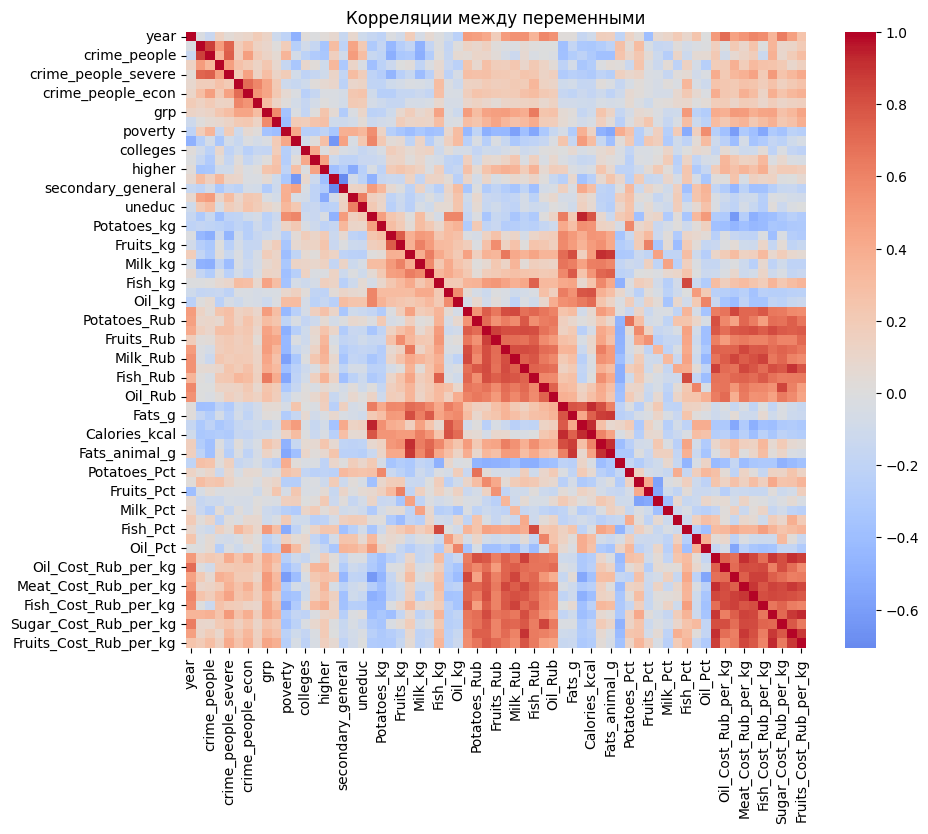

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = panel.select_dtypes(include=[np.number]).corr(method='pearson') 
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Корреляции между переменными')
plt.show()


In [13]:
panel.columns

Index(['region', 'year', 'crime_rate', 'crime_people', 'crime_rate_severe',
       'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
       'crime_rate_corruption', 'grp', 'gini', 'poverty', 'youth', 'colleges',
       'uni', 'higher', 'secondary_prof', 'secondary_general', 'general',
       'uneduc', 'Federal_District_x', 'Bread_kg', 'Potatoes_kg',
       'Vegetables_kg', 'Fruits_kg', 'Meat_kg', 'Milk_kg', 'Eggs_units',
       'Fish_kg', 'Sugar_kg', 'Oil_kg', 'Bread_Rub', 'Potatoes_Rub',
       'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub', 'Milk_Rub', 'Eggs_Rub',
       'Fish_Rub', 'Sugar_Rub', 'Oil_Rub', 'Proteins_g', 'Fats_g', 'Carbs_g',
       'Calories_kcal', 'Proteins_animal_g', 'Fats_animal_g', 'Bread_Pct',
       'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct', 'Milk_Pct',
       'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct', 'Federal_District_y',
       'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_

Корреляция: -0.183


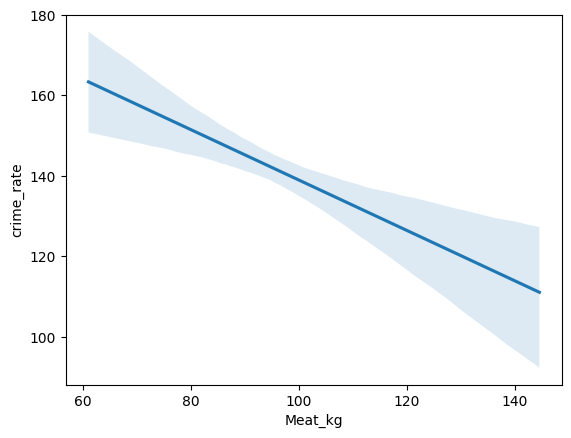

In [14]:
print(f"Корреляция: {panel['Meat_kg'].corr(panel['crime_rate']):.3f}")

sns.regplot(data=panel, x='Meat_kg', y='crime_rate', scatter= False)
plt.show()


In [29]:
factor_vars = [
    'grp', 'gini', 'poverty', 'youth', 'colleges', 'uni', 'higher',
    'secondary_prof', 'secondary_general', 'general', 'uneduc',
    'Federal_District_x',
    'Bread_kg', 'Potatoes_kg', 'Vegetables_kg', 'Fruits_kg', 'Meat_kg',
    'Milk_kg', 'Eggs_units', 'Fish_kg', 'Sugar_kg', 'Oil_kg',
    'Bread_Rub', 'Potatoes_Rub', 'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub',
    'Milk_Rub', 'Eggs_Rub', 'Fish_Rub', 'Sugar_Rub', 'Oil_Rub',
    'Proteins_g', 'Fats_g', 'Carbs_g', 'Calories_kcal',
    'Proteins_animal_g', 'Fats_animal_g',
    'Bread_Pct', 'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct',
    'Milk_Pct', 'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct',
    'Federal_District_y',
    'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
    'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_kg', 'Milk_Cost_Rub_per_kg',
    'Fish_Cost_Rub_per_kg', 'Vegetables_Cost_Rub_per_kg',
    'Sugar_Cost_Rub_per_kg', 'Eggs_Cost_Rub_per_units',
    'Fruits_Cost_Rub_per_kg'
]

crime_vars = [
    'crime_rate', 'crime_people', 'crime_rate_severe',
    'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
    'crime_rate_corruption'
]
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

df = panel.sort_values(["region", "year"]).copy()

max_lag = 5
alpha = 0.05

rows_f2c = []

for factor in factor_vars:
    if factor not in df.columns:
        continue
    if not np.issubdtype(df[factor].dtype, np.number):
        continue

    for crime in crime_vars:
        for lag in range(1, max_lag + 1):
            x = df.groupby("region")[factor].shift(lag)   # прошлый фактор [web:35][web:110]
            y = df[crime]                                 # текущая преступность

            mask = x.notna() & y.notna()
            if mask.sum() < 5:
                continue

            r, p = pearsonr(x[mask], y[mask])            # [web:25][web:109]
            rows_f2c.append({
                "source": factor,
                "target": crime,
                "direction": "factor→crime",
                "lag": lag,
                "r": r,
                "p_value": p
            })

df_f2c = pd.DataFrame(rows_f2c)
rows_c2f = []

for crime in crime_vars:
    for factor in factor_vars:
        if factor not in df.columns:
            continue
        if not np.issubdtype(df[factor].dtype, np.number):
            continue

        for lag in range(1, max_lag + 1):
            x = df.groupby("region")[crime].shift(lag)   # прошлая преступность
            y = df[factor]                               # текущий фактор

            mask = x.notna() & y.notna()
            if mask.sum() < 5:
                continue

            r, p = pearsonr(x[mask], y[mask])
            rows_c2f.append({
                "source": crime,
                "target": factor,
                "direction": "crime→factor",
                "lag": lag,
                "r": r,
                "p_value": p
            })

df_c2f = pd.DataFrame(rows_c2f)
alpha = 0.05

for d in (df_f2c, df_c2f):
    d["abs_r"] = d["r"].abs()

sig_f2c = df_f2c[df_f2c["p_value"] < alpha].sort_values(
    ["abs_r", "lag"], ascending=[False, True]
)
sig_c2f = df_c2f[df_c2f["p_value"] < alpha].sort_values(
    ["abs_r", "lag"], ascending=[False, True]
)
cols = ["direction", "source", "target", "lag", "r", "p_value", "abs_r"]
top1 = sig_f2c[cols]
top2 = sig_c2f[cols]

top_all = pd.concat([top1, top2], axis=0).reset_index(drop=True)
df_correl = top_all
df_correl





,direction,source,target,lag,r,p_value,abs_r
0,factor→crime,general,crime_people,4,0.591051,7.974825e-17,0.591051
1,factor→crime,general,crime_people,5,0.586978,6.801939e-09,0.586978
2,factor→crime,general,crime_rate,4,0.554695,1.291887e-14,0.554695
3,factor→crime,Milk_Cost_Rub_per_kg,crime_people_severe,3,0.552309,4.790370e-21,0.552309
4,factor→crime,general,crime_people,3,0.546593,1.450663e-20,0.546593
...,...,...,...,...,...,...,...
2110,crime→factor,crime_rate_severe,Sugar_Pct,1,-0.099197,4.470627e-02,0.099197
2111,crime→factor,crime_rate_econ,Proteins_g,1,-0.098914,4.532293e-02,0.098914
2112,crime→factor,crime_rate_corruption,Fats_g,1,-0.097588,4.830339e-02,0.097588
2113,crime→factor,crime_people_econ,Carbs_g,1,-0.097357,4.883826e-02,0.097357


In [30]:
# предполагаем, что sig_f2c и sig_c2f уже отфильтрованы по p_value < alpha
# и содержат колонки: source, target, direction, lag, r, p_value

# ключ для пары без направления
sig_f2c["pair"] = sig_f2c["source"] + "||" + sig_f2c["target"]
sig_c2f["pair"] = sig_c2f["target"] + "||" + sig_c2f["source"]
# во втором случае меняем местами, чтобы (factor, crime) совпадали по строке

# пары, где есть и factor→crime, и crime→factor
both_pairs = set(sig_f2c["pair"]) & set(sig_c2f["pair"])

# оставляем только «односторонние» связи
sig_f2c_clean = sig_f2c[~sig_f2c["pair"].isin(both_pairs)].drop(columns=["pair"])
sig_c2f_clean = sig_c2f[~sig_c2f["pair"].isin(both_pairs)].drop(columns=["pair"])

top1 = sig_f2c_clean[cols]
top2 = sig_c2f_clean[cols]

top_all = pd.concat([top1, top2], axis=0).reset_index(drop=True)
df_correl_clean = top_all
df_correl_clean


,direction,source,target,lag,r,p_value,abs_r
0,factor→crime,uneduc,crime_rate_econ,4,0.365724,0.000001,0.365724
1,factor→crime,Sugar_Cost_Rub_per_kg,crime_people,4,0.326358,0.000020,0.326358
2,factor→crime,Sugar_Cost_Rub_per_kg,crime_people,5,0.317899,0.003610,0.317899
3,factor→crime,Sugar_Cost_Rub_per_kg,crime_rate,5,0.298236,0.006500,0.298236
4,factor→crime,Meat_Pct,crime_people,5,-0.295850,0.006963,0.295850
...,...,...,...,...,...,...,...
146,crime→factor,crime_people,Oil_Cost_Rub_per_kg,1,-0.100302,0.042368,0.100302
147,crime→factor,crime_rate_corruption,Carbs_g,1,-0.099711,0.043606,0.099711
148,crime→factor,crime_rate_corruption,Meat_Rub,1,0.099591,0.043861,0.099591
149,crime→factor,crime_rate_severe,Sugar_Pct,1,-0.099197,0.044706,0.099197


<Axes: xlabel='Fish_kg', ylabel='crime_people_severe'>

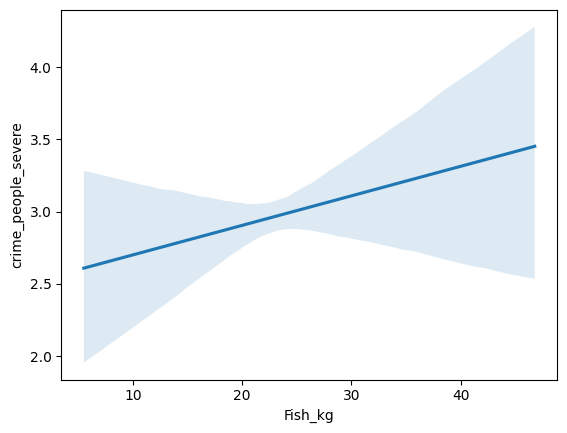

In [17]:
sns.regplot(data = panel, x = 'Fish_kg', y = 'crime_people_severe', scatter = False)


<Axes: xlabel='Fish_kg'>

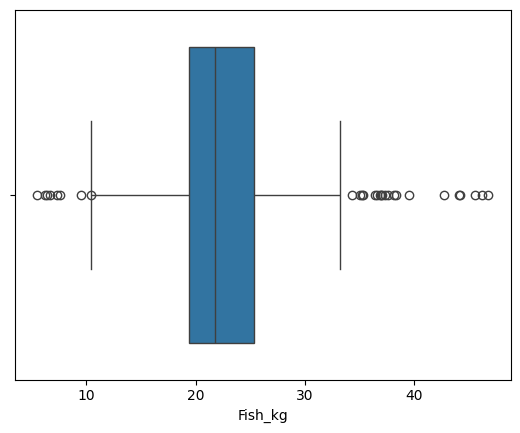

In [18]:
sns.boxplot(data = panel, x = 'Fish_kg',)

In [19]:
fish = panel.Fish_kg

<Axes: xlabel='Fish_kg'>

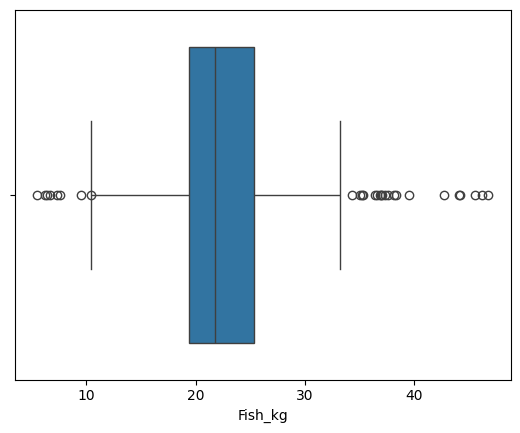

In [20]:
sns.boxplot(data = panel, x = 'Fish_kg',)

In [21]:
panel.Fish_kg  = food.Fish_kg

In [22]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(panel['Fish_kg'], panel['crime_rate'])
print(corr, p_value)



0.0029093959266522054 0.948676006704531


In [23]:
panel.Fish_kg

0      28.065507
1      25.979038
2      25.889719
3      26.277333
4      23.515964
         ...    
487    18.461200
488    22.068900
489    23.375300
490    25.559700
491    26.607600
Name: Fish_kg, Length: 492, dtype: float64

In [24]:
panel.columns

Index(['region', 'year', 'crime_rate', 'crime_people', 'crime_rate_severe',
       'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
       'crime_rate_corruption', 'grp', 'gini', 'poverty', 'youth', 'colleges',
       'uni', 'higher', 'secondary_prof', 'secondary_general', 'general',
       'uneduc', 'Federal_District_x', 'Bread_kg', 'Potatoes_kg',
       'Vegetables_kg', 'Fruits_kg', 'Meat_kg', 'Milk_kg', 'Eggs_units',
       'Fish_kg', 'Sugar_kg', 'Oil_kg', 'Bread_Rub', 'Potatoes_Rub',
       'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub', 'Milk_Rub', 'Eggs_Rub',
       'Fish_Rub', 'Sugar_Rub', 'Oil_Rub', 'Proteins_g', 'Fats_g', 'Carbs_g',
       'Calories_kcal', 'Proteins_animal_g', 'Fats_animal_g', 'Bread_Pct',
       'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct', 'Milk_Pct',
       'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct', 'Federal_District_y',
       'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_

In [26]:
arr = df_correl

In [ ]:
arr.source


0             Milk_Cost_Rub_per_kg
1       Vegetables_Cost_Rub_per_kg
2       Vegetables_Cost_Rub_per_kg
3                          Milk_kg
4             Milk_Cost_Rub_per_kg
                   ...            
1010             crime_rate_severe
1011               crime_rate_econ
1012         crime_rate_corruption
1013             crime_people_econ
1014           crime_people_severe
Name: source, Length: 1015, dtype: object

In [44]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

food_cols = [
    'Bread_kg', 'Potatoes_kg', 'Vegetables_kg', 'Fruits_kg', 'Meat_kg',
    'Milk_kg', 'Eggs_units', 'Fish_kg', 'Sugar_kg', 'Oil_kg',
    'Bread_Rub', 'Potatoes_Rub', 'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub',
    'Milk_Rub', 'Eggs_Rub', 'Fish_Rub', 'Sugar_Rub', 'Oil_Rub',
    'Proteins_g', 'Fats_g', 'Carbs_g', 'Calories_kcal',
    'Proteins_animal_g', 'Fats_animal_g',
    'Bread_Pct', 'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct',
    'Milk_Pct', 'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct',
    'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
    'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_kg', 'Milk_Cost_Rub_per_kg',
    'Fish_Cost_Rub_per_kg', 'Vegetables_Cost_Rub_per_kg',
    'Sugar_Cost_Rub_per_kg', 'Eggs_Cost_Rub_per_units',
    'Fruits_Cost_Rub_per_kg'
]

crime_cols = [
    'crime_rate', 'crime_people', 'crime_rate_severe',
    'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
    'crime_rate_corruption'
]

alpha = 0.05
rows = []

for f in food_cols:
    for c in crime_cols:
        x = panel[f]
        y = panel[c]
        mask = x.notna() & y.notna()
        if mask.sum() < 3:
            continue
        r, p = pearsonr(x[mask], y[mask])
        if p < alpha:          # оставить только значимые
            rows.append({"food_var": f, "crime_var": c, "r": r, "p_value": p})

res_sig = pd.DataFrame(rows)
res_sig["abs_r"] = res_sig["r"].abs()
res_sig = res_sig.sort_values("abs_r", ascending=False)
corr_pearson = pd.concat([res_sig])

In [45]:
corr_pearson

,food_var,crime_var,r,p_value,abs_r
14,Vegetables_kg,crime_people,-0.501829,9.621043e-33,0.501829
30,Milk_kg,crime_people,-0.500649,1.420329e-32,0.500649
198,Vegetables_Cost_Rub_per_kg,crime_people_severe,0.493681,1.372754e-31,0.493681
29,Milk_kg,crime_rate,-0.476929,2.604247e-29,0.476929
16,Vegetables_kg,crime_people_severe,-0.459538,4.480378e-27,0.459538
...,...,...,...,...,...
56,Vegetables_Rub,crime_people,0.094291,3.654530e-02,0.094291
135,Potatoes_Pct,crime_people_severe,0.093081,3.902973e-02,0.093081
105,Fats_g,crime_rate_corruption,-0.091158,4.327566e-02,0.091158
153,Fish_Pct,crime_rate_corruption,0.089793,4.651772e-02,0.089793


<Axes: xlabel='Milk_kg', ylabel='crime_rate'>

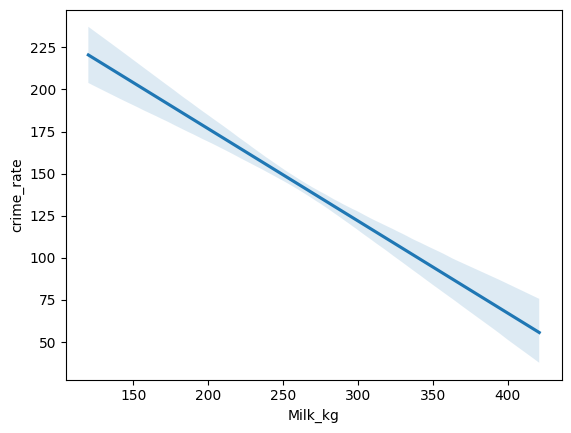

In [47]:
sns.regplot(data = panel, x = 'Milk_kg', y = 'crime_rate', scatter = False)

In [ ]:
import statsmodels.formula.api as smf
import pandas as pd

food_vars = [
    'Bread_kg', 'Potatoes_kg', 'Vegetables_kg', 'Fruits_kg',
    'Meat_kg', 'Milk_kg', 'Eggs_units', 'Fish_kg', 'Sugar_kg', 'Oil_kg'
]

price_vars = ['Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_kg', 'Milk_Cost_Rub_per_kg',
       'Fish_Cost_Rub_per_kg', 'Vegetables_Cost_Rub_per_kg',
       'Sugar_Cost_Rub_per_kg', 'Eggs_Cost_Rub_per_units',
       'Fruits_Cost_Rub_per_kg'
]
results = []

for v in food_vars:
    # 1. простая модель
    m1 = smf.ols(f"crime_rate ~ {v}", data=panel).fit()

    # 2. с контролем (доход, бедность, возраст, образование + цена/расходы на молоко как в примере)
    m2 = smf.ols(
        f"crime_rate ~ {v} + grp + poverty + youth + higher + ",
        data=panel
    ).fit()

    results.append({
        "var": v,
        "beta_simple": m1.params[v],
        "p_simple": m1.pvalues[v],
        "beta_ctrl": m2.params[v],
        "p_ctrl": m2.pvalues[v]
    })

res_df = pd.DataFrame(results)
print(res_df)



             var  beta_simple      p_simple  beta_ctrl        p_ctrl
0       Bread_kg    -0.739585  5.484234e-12  -1.189479  4.760113e-22
1    Potatoes_kg    -0.613221  7.943274e-05  -0.587420  4.907769e-05
2  Vegetables_kg    -1.034140  2.679541e-25  -0.712562  7.131030e-14
3      Fruits_kg    -0.794564  3.768128e-09  -0.278766  3.134668e-02
4        Meat_kg    -0.625902  4.280937e-05  -0.419766  3.850580e-03
5        Milk_kg    -0.547089  2.604247e-29  -0.424855  4.956035e-19
6     Eggs_units    -0.286777  8.775339e-05  -0.304854  7.636620e-06
7        Fish_kg     0.021926  9.486760e-01   0.141877  6.311673e-01
8       Sugar_kg    -1.459610  8.175790e-05  -1.778617  7.503432e-08
9         Oil_kg     0.035661  9.739718e-01  -0.361583  7.259592e-01


In [51]:
panel.columns

Index(['region', 'year', 'crime_rate', 'crime_people', 'crime_rate_severe',
       'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
       'crime_rate_corruption', 'grp', 'gini', 'poverty', 'youth', 'colleges',
       'uni', 'higher', 'secondary_prof', 'secondary_general', 'general',
       'uneduc', 'Federal_District_x', 'Bread_kg', 'Potatoes_kg',
       'Vegetables_kg', 'Fruits_kg', 'Meat_kg', 'Milk_kg', 'Eggs_units',
       'Fish_kg', 'Sugar_kg', 'Oil_kg', 'Bread_Rub', 'Potatoes_Rub',
       'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub', 'Milk_Rub', 'Eggs_Rub',
       'Fish_Rub', 'Sugar_Rub', 'Oil_Rub', 'Proteins_g', 'Fats_g', 'Carbs_g',
       'Calories_kcal', 'Proteins_animal_g', 'Fats_animal_g', 'Bread_Pct',
       'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct', 'Milk_Pct',
       'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct', 'Federal_District_y',
       'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_

In [63]:
panel.columns

Index(['region', 'year', 'crime_rate', 'crime_people', 'crime_rate_severe',
       'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
       'crime_rate_corruption', 'grp', 'gini', 'poverty', 'youth', 'colleges',
       'uni', 'higher', 'secondary_prof', 'secondary_general', 'general',
       'uneduc', 'Federal_District_x', 'Bread_kg', 'Potatoes_kg',
       'Vegetables_kg', 'Fruits_kg', 'Meat_kg', 'Milk_kg', 'Eggs_units',
       'Fish_kg', 'Sugar_kg', 'Oil_kg', 'Bread_Rub', 'Potatoes_Rub',
       'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub', 'Milk_Rub', 'Eggs_Rub',
       'Fish_Rub', 'Sugar_Rub', 'Oil_Rub', 'Proteins_g', 'Fats_g', 'Carbs_g',
       'Calories_kcal', 'Proteins_animal_g', 'Fats_animal_g', 'Bread_Pct',
       'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct', 'Milk_Pct',
       'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct', 'Federal_District_y',
       'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_

In [71]:
from linearmodels.panel import PanelOLS
import pandas as pd

# пусть твой датафрейм называется panel
# region – идентификатор единицы, year – время
panel_fe = panel.set_index(["region", "year"]).sort_index()
exog_vars = ["Milk_kg"]
X = panel_fe[exog_vars]
y = panel_fe["crime_rate"]

mod = PanelOLS(
    y,
    X,
    entity_effects=True,   # фиксированные эффекты регионов
    time_effects=True      # фиксированные эффекты лет
)

res = mod.fit(cov_type="clustered", cluster_entity=True)  # кластер-robust по регионам
print(res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:             crime_rate   R-squared:                        0.0202
Estimator:                   PanelOLS   R-squared (Between):             -0.3539
No. Observations:                 492   R-squared (Within):               0.0088
Date:                 Сб, дек 13 2025   R-squared (Overall):             -0.3523
Time:                        08:28:20   Log-likelihood                   -1817.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.3459
Entities:                          82   P-value                           0.0041
Avg Obs:                       6.0000   Distribution:                   F(1,404)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             11.036
                            

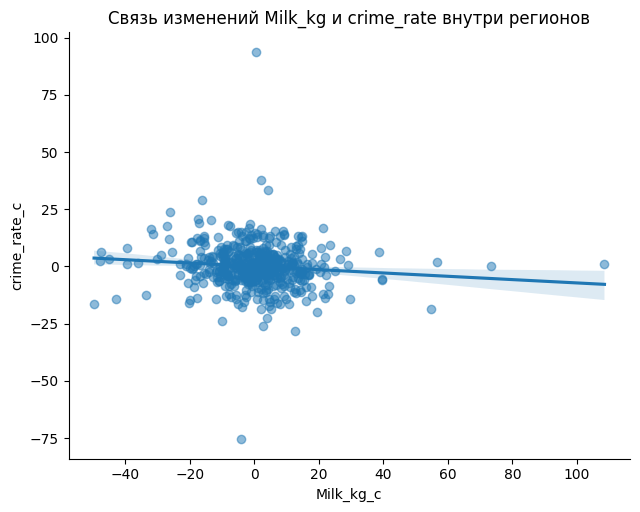

In [75]:
# центрируем по регионам, чтобы приблизить эффект фиксированных эффектов
panel_centered = panel.copy()
panel_centered["Milk_kg_c"] = panel_centered["Milk_kg"] - panel_centered.groupby("region")["Milk_kg"].transform("mean")
panel_centered["crime_rate_c"] = panel_centered["crime_rate"] - panel_centered.groupby("region")["crime_rate"].transform("mean")

sns.lmplot(
    data=panel_centered,
    x="Milk_kg_c",
    y="crime_rate_c",
    height=5,
    aspect=1.3,
    scatter_kws={"alpha": 0.5},
    
)
plt.title("Связь изменений Milk_kg и crime_rate внутри регионов")
plt.show()
